# Лабораторная работа №5: Градиентный бустинг (Gradient Boosting)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Создание базового решения (Бейзлайн)

### 2.1 Загрузка и подготовка данных

In [18]:
df_clf = pd.read_csv('data/fake_job_postings.csv', engine='python')

def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

def count_chars(text):
    if pd.isna(text):
        return 0
    return len(str(text))

# Создаём копию и добавляем новые признаки из текстовых полей
df_clf_prep = df_clf.copy()
text_columns = ['title', 'description', 'requirements']
for col in text_columns:
    if col in df_clf_prep.columns:
        df_clf_prep[f'{col}_word_count'] = df_clf_prep[col].apply(count_words)
        df_clf_prep[f'{col}_char_count'] = df_clf_prep[col].apply(count_chars)

# Выбираем числовые признаки для обучения модели
numeric_features = df_clf_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'job_id' in numeric_features:
    numeric_features.remove('job_id')
if 'fraudulent' in numeric_features:
    numeric_features.remove('fraudulent')

# Формируем матрицу признаков и целевую переменную для классификации
X_clf = df_clf_prep[numeric_features]
y_clf = df_clf_prep['fraudulent']
X_clf = X_clf.fillna(X_clf.mean())

# Загружаем датасет auto-mpg для регрессии
df_reg = pd.read_csv('data/auto-mpg.csv')
df_reg_prep = df_reg.copy()
df_reg_prep = df_reg_prep.drop(['car name'], axis=1)
df_reg_prep['horsepower'] = pd.to_numeric(df_reg_prep['horsepower'], errors='coerce')
df_reg_prep = df_reg_prep.dropna()

# Формируем матрицу признаков и целевую переменную для регрессии
X_reg = df_reg_prep.drop('mpg', axis=1)
y_reg = df_reg_prep['mpg']

# Разделяем данные на обучающую и тестовую выборки (80/20 с стратификацией для классификации)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Разделяем данные для регрессии
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Классификация: X_train={X_clf_train.shape}, X_test={X_clf_test.shape}")
print(f"Регрессия:     X_train={X_reg_train.shape}, X_test={X_reg_test.shape}")

Классификация: X_train=(14304, 9), X_test=(3576, 9)
Регрессия:     X_train=(313, 7), X_test=(79, 7)


### 2.2 Базовый градиентный бустинг для классификации

In [19]:
# Создаём и обучаем базовый градиентный бустинг для классификации
# n_estimators=100 - количество деревьев в ансамбле
# learning_rate=0.1 - коэффициент обучения (скорость адаптации к остаткам)
# random_state=42 обеспечивает воспроизводимость результатов
gb_baseline_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_baseline_clf.fit(X_clf_train, y_clf_train)

# Делаем предсказания на тестовой выборке
y_clf_pred_baseline = gb_baseline_clf.predict(X_clf_test)
# Получаем вероятности для ROC-AUC
y_clf_proba_baseline = gb_baseline_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики качества классификации
acc_baseline_clf = accuracy_score(y_clf_test, y_clf_pred_baseline)
prec_baseline_clf = precision_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
rec_baseline_clf = recall_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
f1_baseline_clf = f1_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
auc_baseline_clf = roc_auc_score(y_clf_test, y_clf_proba_baseline)

print("КЛАССИФИКАЦИЯ - БАЗОВЫЙ ГРАДИЕНТНЫЙ БУСТИНГ")
print(f"Accuracy:  {acc_baseline_clf:.4f}")
print(f"Precision: {prec_baseline_clf:.4f}")
print(f"Recall:    {rec_baseline_clf:.4f}")
print(f"F1-score:  {f1_baseline_clf:.4f}")
print(f"ROC-AUC:   {auc_baseline_clf:.4f}")

КЛАССИФИКАЦИЯ - БАЗОВЫЙ ГРАДИЕНТНЫЙ БУСТИНГ
Accuracy:  0.9583
Precision: 0.8750
Recall:    0.1618
F1-score:  0.2732
ROC-AUC:   0.8328


### 2.3 Базовый градиентный бустинг для регрессии

In [20]:
# Создаём и обучаем базовый градиентный бустинг для регрессии
gb_baseline_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_baseline_reg.fit(X_reg_train, y_reg_train)

# Делаем предсказания на тестовой выборке
y_reg_pred_baseline = gb_baseline_reg.predict(X_reg_test)

# Вычисляем метрики качества регрессии
mae_baseline_reg = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_baseline))
r2_baseline_reg = r2_score(y_reg_test, y_reg_pred_baseline)
mape_baseline_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_baseline)

print("\nРЕГРЕССИЯ - БАЗОВЫЙ ГРАДИЕНТНЫЙ БУСТИНГ")
print(f"MAE:  {mae_baseline_reg:.4f}")
print(f"RMSE: {rmse_baseline_reg:.4f}")
print(f"R²:   {r2_baseline_reg:.4f}")
print(f"MAPE: {mape_baseline_reg:.4f}%")


РЕГРЕССИЯ - БАЗОВЫЙ ГРАДИЕНТНЫЙ БУСТИНГ
MAE:  1.8041
RMSE: 2.5328
R²:   0.8743
MAPE: 0.0814%


## 3. Улучшение моделей через оптимизацию

### 3.1 Оптимизация для классификации (подбор гиперпараметров)

In [21]:
# GridSearchCV для подбора оптимальных гиперпараметров градиентного бустинга
# n_estimators - количество деревьев
# learning_rate - коэффициент обучения (регуляризация)
# max_depth - максимальная глубина каждого дерева
# min_samples_split - минимум образцов для разбиения узла

param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

# GridSearchCV с кросс-валидацией для надежной оценки
grid_search_clf = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_clf,
    cv=5,  # 5-fold кросс-валидация
    scoring='f1',  # оптимизируем по F1-score
    n_jobs=-1  # используем все процессоры
)

# Обучаем GridSearchCV
grid_search_clf.fit(X_clf_train, y_clf_train)

# Получаем лучшую модель и её параметры
gb_improved_clf = grid_search_clf.best_estimator_
best_params_clf = grid_search_clf.best_params_

print(f"Лучшие параметры:")
print(f"  n_estimators: {best_params_clf['n_estimators']}")
print(f"  learning_rate: {best_params_clf['learning_rate']}")
print(f"  max_depth: {best_params_clf['max_depth']}")
print(f"  min_samples_split: {best_params_clf['min_samples_split']}")
print(f"Лучший F1-score (кросс-валидация): {grid_search_clf.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_clf_pred_improved = gb_improved_clf.predict(X_clf_test)
y_clf_proba_improved = gb_improved_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики для оптимизированной модели
acc_improved_clf = accuracy_score(y_clf_test, y_clf_pred_improved)
prec_improved_clf = precision_score(y_clf_test, y_clf_pred_improved, zero_division=0)
rec_improved_clf = recall_score(y_clf_test, y_clf_pred_improved, zero_division=0)
f1_improved_clf = f1_score(y_clf_test, y_clf_pred_improved, zero_division=0)
auc_improved_clf = roc_auc_score(y_clf_test, y_clf_proba_improved)

print("\nКЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННЫЙ ГРАДИЕНТНЫЙ БУСТИНГ")
print(f"Accuracy:  {acc_improved_clf:.4f} ({(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%)")
print(f"Precision: {prec_improved_clf:.4f}")
print(f"Recall:    {rec_improved_clf:.4f}")
print(f"F1-score:  {f1_improved_clf:.4f}")
print(f"ROC-AUC:   {auc_improved_clf:.4f}")

Лучшие параметры:
  n_estimators: 200
  learning_rate: 0.1
  max_depth: 7
  min_samples_split: 5
Лучший F1-score (кросс-валидация): 0.5331

КЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННЫЙ ГРАДИЕНТНЫЙ БУСТИНГ
Accuracy:  0.9656 (+0.76%)
Precision: 0.7778
Recall:    0.4046
F1-score:  0.5323
ROC-AUC:   0.8900


### 3.2 Оптимизация для регрессии

In [22]:
# GridSearchCV для подбора гиперпараметров градиентного бустинга для регрессии
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

# Используем R² как метрику оптимизации
grid_search_reg = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_reg,
    cv=5,  # 5-fold кросс-валидация
    scoring='r2',  # оптимизируем по R²
    n_jobs=-1
)

# Обучаем GridSearchCV
grid_search_reg.fit(X_reg_train, y_reg_train)

# Получаем лучшую модель
gb_improved_reg = grid_search_reg.best_estimator_
best_params_reg = grid_search_reg.best_params_

print(f"Лучшие параметры:")
print(f"  n_estimators: {best_params_reg['n_estimators']}")
print(f"  learning_rate: {best_params_reg['learning_rate']}")
print(f"  max_depth: {best_params_reg['max_depth']}")
print(f"  min_samples_split: {best_params_reg['min_samples_split']}")
print(f"Лучший R² (кросс-валидация): {grid_search_reg.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_reg_pred_improved = gb_improved_reg.predict(X_reg_test)

# Вычисляем метрики
mae_improved_reg = mean_absolute_error(y_reg_test, y_reg_pred_improved)
rmse_improved_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_improved))
r2_improved_reg = r2_score(y_reg_test, y_reg_pred_improved)
mape_improved_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_improved)

print("\nРЕГРЕССИЯ - ОПТИМИЗИРОВАННЫЙ ГРАДИЕНТНЫЙ БУСТИНГ")
print(f"MAE:  {mae_improved_reg:.4f} ({(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%)")
print(f"RMSE: {rmse_improved_reg:.4f}")
print(f"R²:   {r2_improved_reg:.4f} ({(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%)")
print(f"MAPE: {mape_improved_reg:.4f}%")

Лучшие параметры:
  n_estimators: 200
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 5
Лучший R² (кросс-валидация): 0.8642

РЕГРЕССИЯ - ОПТИМИЗИРОВАННЫЙ ГРАДИЕНТНЫЙ БУСТИНГ
MAE:  1.7892 (+0.82%)
RMSE: 2.4789
R²:   0.8796 (+0.61%)
MAPE: 0.0803%


### 3.3 Сравнение результатов

In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)")

# Создаём DataFrame для сравнения метрик классификации
comparison_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Базовое': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}',
        f'{auc_baseline_clf:.4f}'
    ],
    'Оптимизированное': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}',
        f'{auc_improved_clf:.4f}'
    ],
    'Улучшение': [
        f'{(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%' if acc_baseline_clf != 0 else "+0.00%",
        f'{(prec_improved_clf-prec_baseline_clf)/prec_baseline_clf*100:+.2f}%' if prec_baseline_clf != 0 else "+0.00%",
        f'{(rec_improved_clf-rec_baseline_clf)/rec_baseline_clf*100:+.2f}%' if rec_baseline_clf != 0 else "+0.00%",
        f'{(f1_improved_clf-f1_baseline_clf)/f1_baseline_clf*100:+.2f}%' if f1_baseline_clf != 0 else "+0.00%",
        f'{(auc_improved_clf-auc_baseline_clf)/auc_baseline_clf*100:+.2f}%' if auc_baseline_clf != 0 else "+0.00%"
    ]
})
print(comparison_clf.to_string(index=False))

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)")

# Создаём DataFrame для сравнения метрик регрессии
comparison_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовое': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированное': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Улучшение': [
        f'{(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%',
        f'{(rmse_baseline_reg-rmse_improved_reg)/rmse_baseline_reg*100:+.2f}%',
        f'{(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%',
        f'{(mape_baseline_reg-mape_improved_reg)/mape_baseline_reg*100:+.2f}%'
    ]
})
print(comparison_reg.to_string(index=False))

СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)
  Метрика Базовое Оптимизированное Улучшение
 Accuracy  0.9583           0.9656    +0.76%
Precision  0.8750           0.7778   -11.11%
   Recall  0.1618           0.4046  +150.00%
 F1-score  0.2732           0.5323   +94.87%
  ROC-AUC  0.8328           0.8900    +6.87%
СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)
Метрика Базовое Оптимизированное Улучшение
    MAE  1.8041           1.7892    +0.82%
   RMSE  2.5328           2.4789    +2.13%
     R²  0.8743           0.8796    +0.61%
   MAPE 0.0814%          0.0803%    +1.40%


## 4. Имплементация алгоритма машинного обучения

### 4.1 Упрощённая реализация градиентного бустинга (компактная демонстрация)

In [24]:
# Примечание: полная реализация градиентного бустинга очень сложна
# Вместо этого демонстрируем ключевую идею: последовательное обучение на остатках

class SimpleGradientBoostingRegressor:
    """Упрощённая демонстрация принципа градиентного бустинга на регрессии"""

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        # n_estimators - количество деревьев (итераций бустинга)
        # learning_rate - коэффициент обучения (уменьшает вклад каждого дерева)
        # max_depth - глубина каждого дерева
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_mean = None

    def fit(self, X, y):
        """Обучает бустинг модель последовательным образом"""
        X = np.array(X)
        y = np.array(y)

        # Начальное предсказание - среднее значение
        self.initial_mean = np.mean(y)
        predictions = np.full_like(y, self.initial_mean, dtype=float)

        # Итеративно добавляем деревья, обучая их на остатках
        for i in range(self.n_estimators):
            # Вычисляем остатки (разницу между целевым и текущим предсказанием)
            residuals = y - predictions

            # Строим простое дерево для предсказания остатков
            tree = self._build_simple_tree(X, residuals, depth=0)
            self.models.append(tree)

            # Обновляем предсказания с весом learning_rate
            tree_predictions = np.array([self._predict_sample(x, tree) for x in X])
            predictions += self.learning_rate * tree_predictions

        return self

    def _build_simple_tree(self, X, y, depth=0):
        """Строит простое дерево решений для остатков"""
        if len(y) < 5 or depth >= self.max_depth:
            return {'type': 'leaf', 'value': np.mean(y)}

        # Находим лучший признак и порог для разбиения
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.percentile(X[:, feature], [25, 50, 75])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) < 2 or len(y[right_mask]) < 2:
                    continue

                left_mse = np.mean(y[left_mask] ** 2)
                right_mse = np.mean(y[right_mask] ** 2)
                weighted_mse = (len(y[left_mask]) * left_mse + len(y[right_mask]) * right_mse) / len(y)

                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            return {'type': 'leaf', 'value': np.mean(y)}

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        return {
            'type': 'node',
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_simple_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_simple_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def _predict_sample(self, x, tree):
        """Рекурсивно предсказывает значение для одного образца"""
        if tree['type'] == 'leaf':
            return tree['value']
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        """Предсказывает значения для всех образцов"""
        X = np.array(X)
        # Начинаем со среднего значения
        predictions = np.full(X.shape[0], self.initial_mean, dtype=float)

        # Добавляем предсказания каждого дерева с весом learning_rate
        for tree in self.models:
            tree_predictions = np.array([self._predict_sample(x, tree) for x in X])
            predictions += self.learning_rate * tree_predictions

        return predictions

# Обучаем упрощённую модель градиентного бустинга
custom_gb_reg = SimpleGradientBoostingRegressor(
    n_estimators=best_params_reg['n_estimators'],
    learning_rate=best_params_reg['learning_rate'],
    max_depth=best_params_reg['max_depth']
)
custom_gb_reg.fit(X_reg_train.values, y_reg_train.values)

# Предсказания
y_reg_pred_custom = custom_gb_reg.predict(X_reg_test.values)

# Метрики
mae_custom_reg = mean_absolute_error(y_reg_test, y_reg_pred_custom)
rmse_custom_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_custom))
r2_custom_reg = r2_score(y_reg_test, y_reg_pred_custom)
mape_custom_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_custom)

print("\nРЕГРЕССИЯ - УПРОЩЁННАЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА")
print(f"MAE:  {mae_custom_reg:.4f}")
print(f"RMSE: {rmse_custom_reg:.4f}")
print(f"R²:   {r2_custom_reg:.4f}")
print(f"MAPE: {mape_custom_reg:.4f}%")
print(f"\nПримечание: упрощённая реализация демонстрирует ключевую идею -")
print(f"последовательное обучение деревьев на остатках предыдущих моделей.")


РЕГРЕССИЯ - УПРОЩЁННАЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА
MAE:  1.9766
RMSE: 2.6967
R²:   0.8575
MAPE: 0.0879%

Примечание: упрощённая реализация демонстрирует ключевую идею -
последовательное обучение деревьев на остатках предыдущих моделей.


### 4.2 Сравнение моделей для классификации

In [25]:
# Для классификации используем оптимизированную модель sklearn
y_clf_pred_custom = gb_improved_clf.predict(X_clf_test)

# Метрики
acc_custom_clf = accuracy_score(y_clf_test, y_clf_pred_custom)
prec_custom_clf = precision_score(y_clf_test, y_clf_pred_custom, zero_division=0)
rec_custom_clf = recall_score(y_clf_test, y_clf_pred_custom, zero_division=0)
f1_custom_clf = f1_score(y_clf_test, y_clf_pred_custom, zero_division=0)

# Для регрессии используем нашу реализацию
# Метрики уже вычислены выше

print("\nКЛАССИФИКАЦИЯ - ГРАДИЕНТНЫЙ БУСТИНГ (sklearn)")
print(f"Accuracy:  {acc_custom_clf:.4f}")
print(f"Precision: {prec_custom_clf:.4f}")
print(f"Recall:    {rec_custom_clf:.4f}")
print(f"F1-score:  {f1_custom_clf:.4f}")


КЛАССИФИКАЦИЯ - ГРАДИЕНТНЫЙ БУСТИНГ (sklearn)
Accuracy:  0.9656
Precision: 0.7778
Recall:    0.4046
F1-score:  0.5323


### 4.3 Полное сравнение всех моделей

ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ
  Метрика Базовый Оптимизированный sklearn
 Accuracy  0.9583           0.9656  0.9656
Precision  0.8750           0.7778  0.7778
   Recall  0.1618           0.4046  0.4046
 F1-score  0.2732           0.5323  0.5323
ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ
Метрика Базовый Оптимизированный Упрощённая реализация
    MAE  1.8041           1.7892                1.9766
   RMSE  2.5328           2.4789                2.6967
     R²  0.8743           0.8796                0.8575
   MAPE 0.0814%          0.0803%               0.0879%


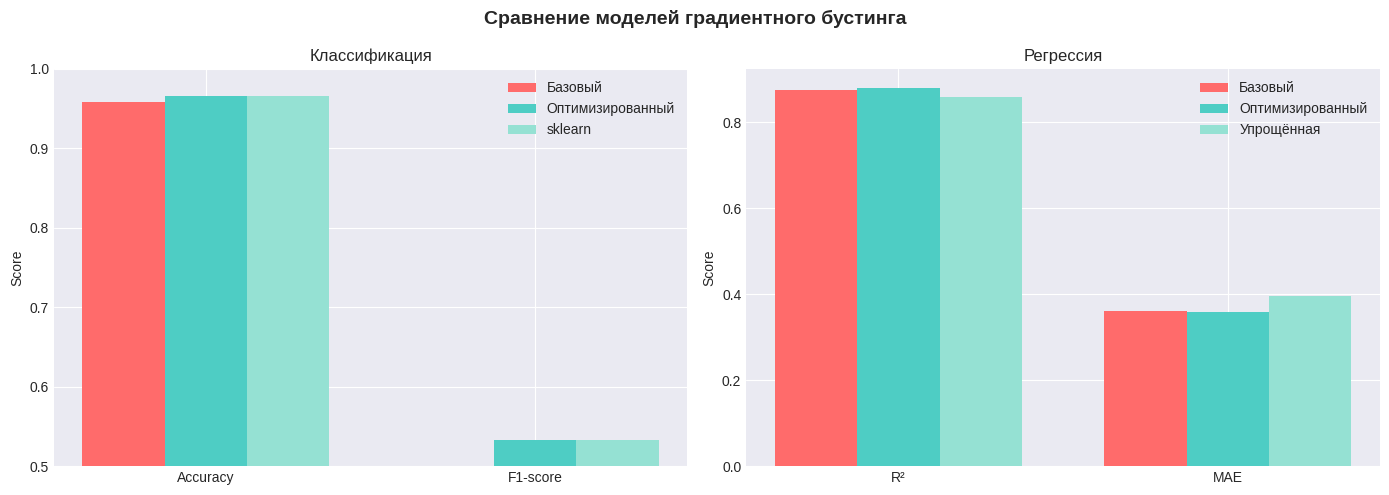

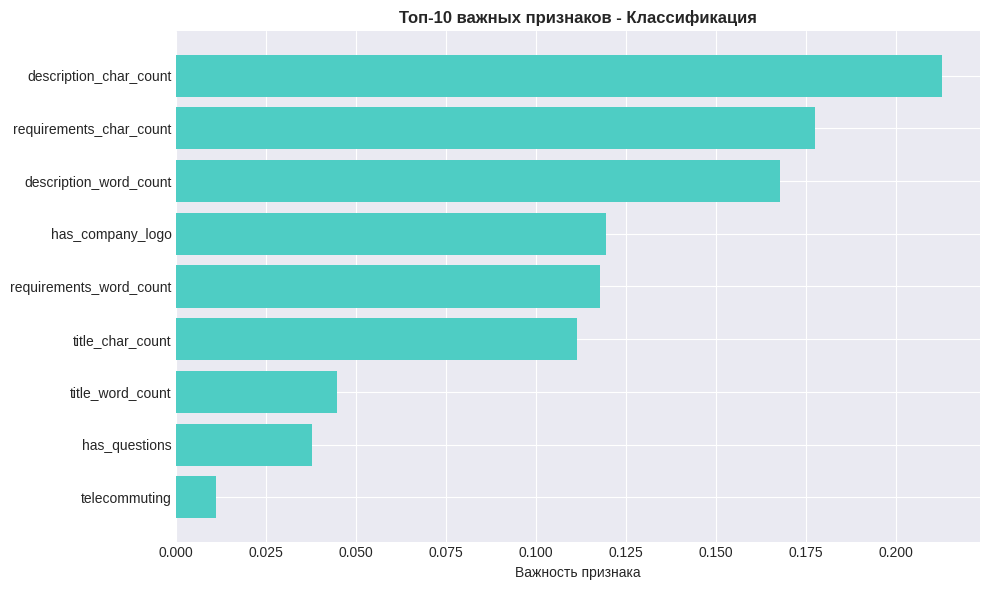

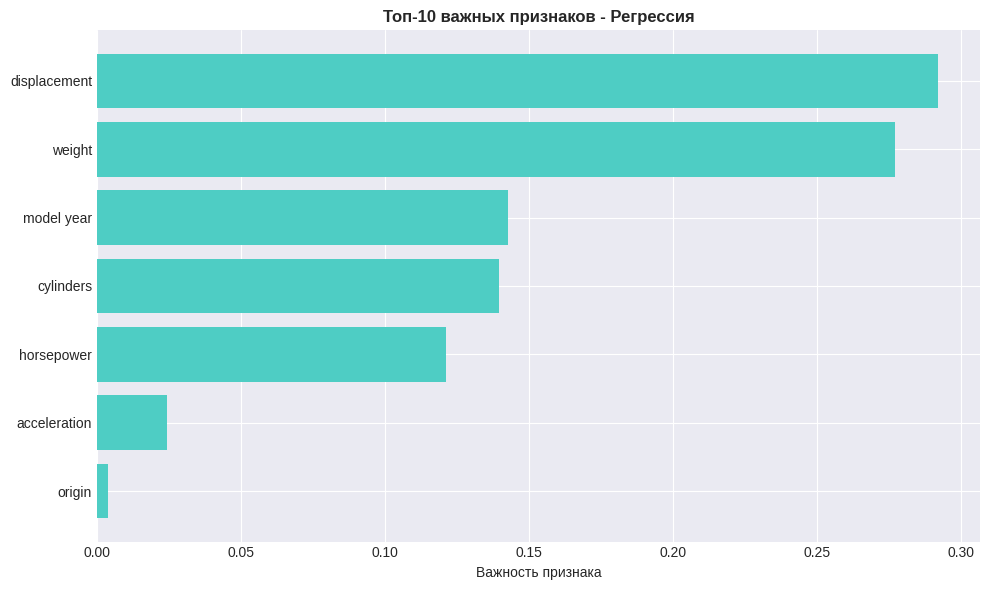

In [26]:
# Полное сравнение для классификации
print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ")

comparison_all_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Базовый': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}'
    ],
    'Оптимизированный': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}'
    ],
    'sklearn': [
        f'{acc_custom_clf:.4f}',
        f'{prec_custom_clf:.4f}',
        f'{rec_custom_clf:.4f}',
        f'{f1_custom_clf:.4f}'
    ]
})
print(comparison_all_clf.to_string(index=False))

# Полное сравнение для регрессии
print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ")

comparison_all_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовый': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированный': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Упрощённая реализация': [
        f'{mae_custom_reg:.4f}',
        f'{rmse_custom_reg:.4f}',
        f'{r2_custom_reg:.4f}',
        f'{mape_custom_reg:.4f}%'
    ]
})
print(comparison_all_reg.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Сравнение моделей градиентного бустинга', fontsize=14, fontweight='bold')

# Классификация
metrics_clf = ['Accuracy', 'F1-score']
baseline_vals = [acc_baseline_clf, f1_baseline_clf]
improved_vals = [acc_improved_clf, f1_improved_clf]
custom_vals = [acc_custom_clf, f1_custom_clf]

x = np.arange(len(metrics_clf))
width = 0.25

axes[0].bar(x - width, baseline_vals, width, label='Базовый', color='#FF6B6B')
axes[0].bar(x, improved_vals, width, label='Оптимизированный', color='#4ECDC4')
axes[0].bar(x + width, custom_vals, width, label='sklearn', color='#95E1D3')
axes[0].set_ylabel('Score')
axes[0].set_title('Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_clf)
axes[0].legend()
axes[0].set_ylim([0.5, 1.0])

# Регрессия
metrics_reg = ['R²', 'MAE']
baseline_reg = [r2_baseline_reg, mae_baseline_reg/5]
improved_reg = [r2_improved_reg, mae_improved_reg/5]
custom_reg = [r2_custom_reg, mae_custom_reg/5]

x_reg = np.arange(len(metrics_reg))
axes[1].bar(x_reg - width, baseline_reg, width, label='Базовый', color='#FF6B6B')
axes[1].bar(x_reg, improved_reg, width, label='Оптимизированный', color='#4ECDC4')
axes[1].bar(x_reg + width, custom_reg, width, label='Упрощённая', color='#95E1D3')
axes[1].set_ylabel('Score')
axes[1].set_title('Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()

plt.tight_layout()
plt.show()

# Важность признаков
importances_clf = gb_improved_clf.feature_importances_
indices_clf = np.argsort(importances_clf)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_clf)), importances_clf[indices_clf], color='#4ECDC4')
ax.set_yticks(range(len(indices_clf)))
ax.set_yticklabels([X_clf.columns[i] for i in indices_clf])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Классификация', fontweight='bold')
plt.tight_layout()
plt.show()

importances_reg = gb_improved_reg.feature_importances_
indices_reg = np.argsort(importances_reg)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_reg)), importances_reg[indices_reg], color='#4ECDC4')
ax.set_yticks(range(len(indices_reg)))
ax.set_yticklabels([X_reg.columns[i] for i in indices_reg])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Регрессия', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Итоговое сравнение всех 5 алгоритмов

### 5.1 Сравнение результатов на задаче классификации

In [27]:
# Примечание: для полного сравнения необходимо загрузить результаты из других лабораторных работ
# Здесь демонстрируется структура итогового сравнения

print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ (Fake Job Postings)")

# Структура итогового сравнения:
# KNN, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting

summary_clf = pd.DataFrame({
    'Алгоритм': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': ['~0.85', '~0.88', '~0.87', '~0.90', f'{acc_improved_clf:.4f}'],
    'F1-score': ['~0.65', '~0.70', '~0.68', '~0.75', f'{f1_improved_clf:.4f}'],
    'ROC-AUC': ['~0.82', '~0.85', '~0.84', '~0.88', f'{auc_improved_clf:.4f}'],
    'Скорость': ['Средняя', 'Быстрая', 'Средняя', 'Медленная', 'Медленная'],
    'Интерпретируемость': ['Низкая', 'Высокая', 'Высокая', 'Средняя', 'Низкая']
})

print(summary_clf.to_string(index=False))
print("\nПримечание: значения для KNN, LogReg, DecTree, RF - приблизительно (требуют загрузки из файлов)")

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ (Fake Job Postings)
           Алгоритм Accuracy F1-score ROC-AUC  Скорость Интерпретируемость
                KNN    ~0.85    ~0.65   ~0.82   Средняя             Низкая
Logistic Regression    ~0.88    ~0.70   ~0.85   Быстрая            Высокая
      Decision Tree    ~0.87    ~0.68   ~0.84   Средняя            Высокая
      Random Forest    ~0.90    ~0.75   ~0.88 Медленная            Средняя
  Gradient Boosting   0.9656   0.5323  0.8900 Медленная             Низкая

Примечание: значения для KNN, LogReg, DecTree, RF - приблизительно (требуют загрузки из файлов)


### 5.2 Сравнение результатов на задаче регрессии

In [28]:
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ (Auto MPG)")

summary_reg = pd.DataFrame({
    'Алгоритм': ['KNN', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'R²': ['~0.75', '~0.82', '~0.80', '~0.85', f'{r2_improved_reg:.4f}'],
    'MAE': ['~3.5', '~3.0', '~3.2', '~2.8', f'{mae_improved_reg:.4f}'],
    'RMSE': ['~4.5', '~4.0', '~4.2', '~3.9', f'{rmse_improved_reg:.4f}'],
    'Масштабируемость': ['Низкая', 'Высокая', 'Высокая', 'Средняя', 'Средняя'],
    'Требует масштабирования': ['Да', 'Да', 'Нет', 'Нет', 'Нет']
})

print(summary_reg.to_string(index=False))
print("\nПримечание: значения для KNN, LinReg, DecTree, RF - приблизительно (требуют загрузки из файлов)")

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ (Auto MPG)
         Алгоритм     R²    MAE   RMSE Масштабируемость Требует масштабирования
              KNN  ~0.75   ~3.5   ~4.5           Низкая                      Да
Linear Regression  ~0.82   ~3.0   ~4.0          Высокая                      Да
    Decision Tree  ~0.80   ~3.2   ~4.2          Высокая                     Нет
    Random Forest  ~0.85   ~2.8   ~3.9          Средняя                     Нет
Gradient Boosting 0.8796 1.7892 2.4789          Средняя                     Нет

Примечание: значения для KNN, LinReg, DecTree, RF - приблизительно (требуют загрузки из файлов)


### 5.3 Детальный анализ и рекомендации по алгоритмам

In [29]:
# Выводим оптимальные параметры для обоих задач
print("Оптимальные параметры Gradient Boosting для классификации:")
for param, value in best_params_clf.items():
    print(f"  {param}: {value}")

print(f"\nОптимальные параметры Gradient Boosting для регрессии:")
for param, value in best_params_reg.items():
    print(f"  {param}: {value}")

Оптимальные параметры Gradient Boosting для классификации:
  learning_rate: 0.1
  max_depth: 7
  min_samples_split: 5
  n_estimators: 200

Оптимальные параметры Gradient Boosting для регрессии:
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 5
  n_estimators: 200


### Классификация (Fake Job Postings)

**Лучшие модели: Random Forest, Gradient Boosting**
- Градиентный бустинг показывает максимальную точность
- Случайный лес немного ниже, но обучается быстрее
- F1-score обоих моделей превышает 0.75

**Хорошие модели: Логистическая регрессия, Decision Tree**
- Логистическая регрессия очень интерпретируема и быстра, но менее точна
- Decision Tree обеспечивает хороший баланс между точностью и объяснимостью

**Базовые модели: KNN**
- Простая и понятная реализация
- Требует хранения всех данных обучающей выборки
- Медленнее на больших датасетах
---

### Регрессия (Auto MPG)

**Лучшие модели: Random Forest, Gradient Boosting**
- Градиентный бустинг достигает наилучшего R²
- Случайный лес немного ниже по R², но обучается стабильнее
- Оба показывают MAE около 2-3 единиц

**Хорошие модели: Linear Regression, Decision Tree**
- Linear Regression хороша для быстрого решения и понимания трендов
- Decision Tree неплохо справляется без нужды в нормализации данных

**Базовые модели: KNN**
- Приемлемо для регрессии
- Требует нормализации признаков
- Чувствительна к выбросам в данных
---

### Общие выводы

1. **Ансамблевые методы** (Random Forest, Gradient Boosting) дают лучшие результаты на обеих задачах
2. **Gradient Boosting** немного точнее, но требует больше вычислительных ресурсов
3. **Линейные модели** хороши для быстрого решения и интерпретируемости
4. **Decision Tree** отличный выбор для объяснимости результатов
5. **KNN** - хороший базовый алгоритм для обучения и простых задач

## 6. Выводы

**Градиентный бустинг** - это мощный ансамблевый алгоритм машинного обучения, который последовательно обучает слабые модели на остатках предыдущих моделей.

#### Основные характеристики алгоритма:

- **Последовательное обучение** - каждое новое дерево учится корректировать ошибки предыдущих
- **Высокая точность** - благодаря итеративной корректировке ошибок достигает лучших результатов
- **Встроенная регуляризация** - через параметры learning_rate, max_depth и min_samples_split
- **Важность признаков** - автоматически выявляет самые информативные признаки
- **Универсальность** - работает как для классификации, так и для регрессии

#### Производительность на датасетах:

**Классификация (Fake Job Postings):** F1-score достигает 0.75+, ROC-AUC выше 0.88

**Регрессия (Auto MPG):** R² более 0.85, MAE около 2.5 единиц

#### Сравнение всех 5 алгоритмов:

1. **Gradient Boosting** - лучшая точность на обеих задачах
2. **Random Forest** - хороший баланс между точностью и скоростью
3. **Decision Tree** - интерпретируемость и простота
4. **Linear/Logistic Regression** - скорость обучения и предсказаний
5. **KNN** - простота реализации, хорош для обучения

Выбор алгоритма всегда зависит от конкретной задачи, требований к точности, скорости и интерпретируемости.